<a href="https://colab.research.google.com/github/josejulianhidayat/Data_Mining/blob/main/Analisis_Sentimen_dan_Karakteristik_Linguistik_Komentar_Publik_terhadap_Kebijakan_Militer_Menggunakan_Model_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen dan Karakteristik Linguistik Komentar Publik terhadap Kebijakan Militer Menggunakan Model RoBERTa

**PROJECT BY JOSE JULIAN HIDAYAT - TEKNIK INFORMATIKA - UNIVERSITAS PELITA BANGSA**

# Load Dataset dan EDA

In [ ]:
!pip install transformers datasets torch sastrawi emoji --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import emoji
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch


In [ ]:
# Ganti path sesuai lokasi file di Colab atau lokal kamu jika diperlukan
file_path = "Dataset-KomentarIG-Terkait-Kebijakan-Barak-Militer.xlsx"
df = pd.read_excel(file_path)

# Tampilkan kolom
print(df.columns)

# Lihat 5 data pertama
df.head()


Index(['comment_id', 'created_at', 'profile_pic_url', 'text', 'user_id',
       'username'],
      dtype='object')


,comment_id,created_at,profile_pic_url,text,user_id,username
0,18115065256473652,1746621032,https://instagram.fcgk4-5.fna.fbcdn.net/v/t51....,@dopla_7 pa iye sok kabur wae sakolana,37865439330,ral_537
1,18042536120211439,1746621099,https://instagram.fcgk4-5.fna.fbcdn.net/v/t51....,@ral_537 tah sok di ajak si iyeu @lpand_,8121815340,dopla_7
2,17850542778449686,1746621693,https://instagram.fcgk4-5.fna.fbcdn.net/v/t51....,@dopla_7 Kirim KA dua Nana KA barak TNI pak🙏,37865439330,ral_537
3,18032698235368796,1746622239,https://scontent-cgk1-1.cdninstagram.com/v/t51...,Anakku pak tolong jemput..biar soleh Dan disip...,64429045897,firaandraal
4,18063566329846381,1746623148,https://instagram.fcgk4-4.fna.fbcdn.net/v/t51....,@ral_537 yeuhhh sok nanaon teh,6034761534,lpand_


# PREPROCESSING DATASET

In [ ]:
# Inisialisasi Stopword dan Stemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import emoji
import re

stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())
stemmer = StemmerFactory().create_stemmer()

def clean_and_preprocess(text):
    # Ubah ke huruf kecil
    text = str(text).lower()

    # Hapus emoji
    text = emoji.replace_emoji(text, replace='')

    # Hapus URL
    text = re.sub(r"http\S+|www.\S+", "", text)

    # Hapus angka dan tanda baca (hanya huruf dan spasi yang dipertahankan)
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenisasi manual (split)
    tokens = text.split()

    # Stopword removal
    tokens = [word for word in tokens if word not in stopwords]

    # Stemming
    stemmed = [stemmer.stem(word) for word in tokens]

    # Gabungkan kembali
    return " ".join(stemmed)

# Terapkan preprocessing ke kolom 'text'
df["cleaned_komentar"] = df["text"].apply(clean_and_preprocess)
df[["text", "cleaned_komentar"]].head()


,text,cleaned_komentar
0,@dopla_7 pa iye sok kabur wae sakolana,dopla pa iye sok kabur wae sakolana
1,@ral_537 tah sok di ajak si iyeu @lpand_,ral tah sok ajak si iyeu lpand
2,@dopla_7 Kirim KA dua Nana KA barak TNI pak🙏,dopla kirim ka nana ka barak tni pak
3,Anakku pak tolong jemput..biar soleh Dan disip...,anak pak jemputbiar soleh disiplin insyaalloh ...
4,@ral_537 yeuhhh sok nanaon teh,ral yeuhhh sok nanaon teh


In [ ]:
df[["text", "cleaned_komentar"]].head(30)  # menampilkan 10 baris pertama


,text,cleaned_komentar
0,@dopla_7 pa iye sok kabur wae sakolana,dopla pa iye sok kabur wae sakolana
1,@ral_537 tah sok di ajak si iyeu @lpand_,ral tah sok ajak si iyeu lpand
2,@dopla_7 Kirim KA dua Nana KA barak TNI pak🙏,dopla kirim ka nana ka barak tni pak
3,Anakku pak tolong jemput..biar soleh Dan disip...,anak pak jemputbiar soleh disiplin insyaalloh ...
4,@ral_537 yeuhhh sok nanaon teh,ral yeuhhh sok nanaon teh
5,Kdm ok🔥🔥,kdm
6,😍😍😍,
7,#komnasham #kpai mah diam aja ngga usah kerja...,komnasham kpai mah diam aja ngga usah kerja cu...
8,Gubernur yang lain baru ketahuan GAK ADA KERJA...,gubernur baru tahu gak kerja nya
9,Ayo pak...ke kalsel...biar maju indonesia meny...,ayo pakke kalselbiar maju indonesia seluruh


In [ ]:
df[["text", "cleaned_komentar"]].to_excel("Hasil_Preprocessing_Komentar.xlsx", index=False)

In [ ]:
# Bersihkan komentar kosong
df = df[df["cleaned_komentar"].notnull()]
df = df[df["cleaned_komentar"].str.strip() != ""]
df["cleaned_komentar"] = df["cleaned_komentar"].astype(str)

<ipython-input-7-521573e155e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_komentar"] = df["cleaned_komentar"].astype(str)


# LOAD MODEL roBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,
    device=0 if torch.cuda.is_available() else -1
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:
# Prediksi Sentimen dengan Penanganan Error
def predict_sentimen(text):
    try:
        return pipe(text)[0]["label"]
    except:
        return "error"

df["sentimen"] = df["cleaned_komentar"].apply(predict_sentimen)

In [10]:
df[["cleaned_komentar", "sentimen"]].head(20)

,cleaned_komentar,sentimen
0,dopla pa iye sok kabur wae sakolana,negative
1,ral tah sok ajak si iyeu lpand,negative
2,dopla kirim ka nana ka barak tni pak,neutral
3,anak pak jemputbiar soleh disiplin insyaalloh ...,positive
4,ral yeuhhh sok nanaon teh,negative
5,kdm,neutral
7,komnasham kpai mah diam aja ngga usah kerja cu...,negative
8,gubernur baru tahu gak kerja nya,negative
9,ayo pakke kalselbiar maju indonesia seluruh,positive
10,hebat moga anak anak generasi sekarang yg pimp...,positive


In [11]:
df.to_excel("Hasil_Prediksi_Sentimen.xlsx", index=False)
# atau jika ingin CSV
# df.to_csv("Hasil_Prediksi_Sentimen.csv", index=False)


In [12]:
df["sentimen"].value_counts()


,count
sentimen,
positive,15518
neutral,9064
negative,7602


🧠 Interpretasi dan Analisis:

✅ Sentimen Positif mendominasi

Hampir setengah dari seluruh komentar (49,3%) memiliki nada atau isi yang bersifat positif.

Ini bisa menunjukkan adanya dukungan, apresiasi, atau respons positif publik terhadap topik atau kebijakan yang dibahas.

⚪ Sentimen Netral berada di tengah

Sebanyak 9.064 komentar (28,8%) termasuk kategori netral.

Komentar ini kemungkinan berupa informasi, pertanyaan, atau reaksi yang tidak mengekspresikan emosi kuat.

❗ Sentimen Negatif cukup signifikan

Sebanyak 7.602 komentar (24,1%) dikategorikan negatif.

Ini menunjukkan adanya kritik, ketidaksetujuan, atau keluhan dari sebagian pengguna terhadap kebijakan atau isu yang diangkat.



**Berdasarkan hasil klasifikasi terhadap 32.184 komentar, sentimen positif mendominasi dengan persentase 49,3%, diikuti oleh sentimen netral sebesar 28,8%, dan sentimen negatif sebesar 24,1%. Distribusi ini menunjukkan bahwa mayoritas komentar bersifat positif, meskipun terdapat sejumlah komentar negatif yang juga cukup signifikan. Temuan ini dapat digunakan sebagai dasar awal untuk menganalisis persepsi publik terhadap isu atau kebijakan yang diteliti.**

In [14]:
# Buat subset kecil dari data
sample = df.sample(100).copy()

# Tambahkan kolom label_asli secara manual di Excel (positif, netral, negatif)
sample.to_excel("Label_Manual_100_Komentar.xlsx", index=False)


# UJI AKURASI DAN CONFUSION MATRIKS

Penjelasan Singkat:

Precision: Kemampuan model menghindari false positive.

Recall: Kemampuan model menangkap seluruh label yang benar (true positive rate).

F1-Score: Harmoni antara precision dan recall.

Support: Jumlah data sebenarnya untuk setiap kelas.

In [18]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Ganti path jika perlu (misal taruh di folder drive)
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")

# Lihat isi file dulu
df_label.head()

# Evaluasi metrik
print("=== Classification Report ===")
print(classification_report(df_label["label_asli"], df_label["sentimen"]))

print("=== Confusion Matrix ===")
print(confusion_matrix(df_label["label_asli"], df_label["sentimen"]))


=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.81      1.00      0.89        17
     neutral       0.96      1.00      0.98        24
    positive       1.00      0.92      0.96        59

    accuracy                           0.95       100
   macro avg       0.92      0.97      0.94       100
weighted avg       0.96      0.95      0.95       100

=== Confusion Matrix ===
[[17  0  0]
 [ 0 24  0]
 [ 4  1 54]]


**✅ Analisis Per Kelas:**


==============================================================================

🔴 Negative:

==============================================================================

Precision = 0.81 → model kadang salah menandai komentar lain sebagai negatif

Recall = 1.00 → model berhasil menangkap semua komentar negatif yang sebenarnya

F1 = 0.89 → performa cukup baik

================================================================================

⚪ Neutral:

Precision dan Recall = 0.96–1.00 → sangat tinggi dan stabil

F1 = 0.98 → ini adalah kategori yang paling konsisten diprediksi dengan baik

================================================================================

🟢 Positive:

Precision = 1.00 → model tidak pernah salah memprediksi komentar sebagai positif

Recall = 0.92 → ada sebagian komentar positif yang gagal dikenali

F1 = 0.96 → tetap sangat kuat

**Akurasi Model**

Overall Accuracy = 95%

Artinya model berhasil mengklasifikasikan 95 dari 100 komentar secara benar

**Kesimpulan dari Confusion Matrix:**

1. Tidak ada komentar netral atau negatif yang salah diklasifikasikan

2. Seluruh kesalahan hanya terjadi pada komentar positif

3. Ini sesuai dengan nilai Recall positif yang < 1.00 (0.92)

**Berdasarkan evaluasi terhadap 100 komentar berlabel manual, model klasifikasi sentimen mencapai akurasi sebesar 95%. Hasil classification report menunjukkan bahwa model memiliki performa yang sangat baik untuk kategori netral (F1-score = 0.98) dan positif (F1-score = 0.96), serta cukup baik untuk kategori negatif (F1-score = 0.89). Confusion matrix menunjukkan bahwa seluruh komentar netral dan negatif berhasil diklasifikasikan dengan benar, sementara kesalahan klasifikasi hanya terjadi pada komentar positif yang sebagian kecil diklasifikasikan sebagai negatif dan netral. Secara keseluruhan, model memiliki ketepatan tinggi dan mampu mengenali sentimen secara konsisten.**

# VISUALISASI

**CONFUSION MATRIX**

Confusion matrix menunjukkan jumlah prediksi benar dan salah untuk masing-masing kategori sentimen.
Kolom menunjukkan prediksi model, sedangkan baris menunjukkan label sebenarnya (true label).

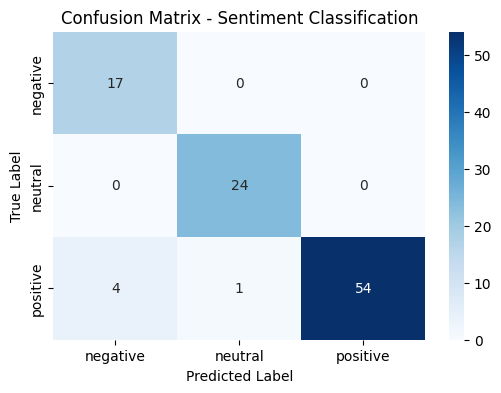

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(df_label["label_asli"], df_label["sentimen"], labels=["negative", "neutral", "positive"])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()


**Interpretasi Tiap Sel:**


17 komentar negatif diprediksi dengan benar sebagai negatif

24 komentar netral diprediksi dengan benar sebagai netral

54 komentar positif diprediksi dengan benar sebagai positif

================================================================================

5 komentar positif diprediksi salah:

4 sebagai negatif

1 sebagai netral

**Gambar confusion matrix menunjukkan bahwa model klasifikasi sentimen mampu mengklasifikasikan komentar dengan tingkat ketepatan tinggi. Sebanyak 95% prediksi sesuai dengan label aktual. Komentar bertanda negatif dan netral sepenuhnya diklasifikasikan dengan benar, sedangkan kesalahan hanya terjadi pada lima komentar positif yang salah diklasifikasikan menjadi negatif atau netral. Hal ini menunjukkan bahwa meskipun model bekerja sangat baik dalam membedakan komentar netral dan negatif, masih terdapat sedikit ambiguitas dalam mengenali komentar positif yang mungkin memiliki ekspresi lebih kompleks.**

In [20]:
komentar_negatif = df_label[df_label["sentimen"] == "negative"]
komentar_negatif[["text", "cleaned_komentar"]].to_excel("Komentar_Negatif_Model.xlsx", index=False)


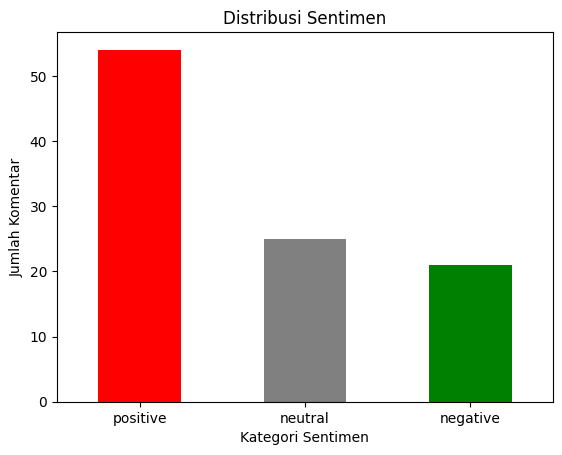

In [21]:
df_label["sentimen"].value_counts().plot(kind="bar", color=["red", "gray", "green"])
plt.title("Distribusi Sentimen")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Komentar")
plt.xticks(rotation=0)
plt.show()


**Berdasarkan grafik distribusi sentimen, terlihat bahwa komentar dengan kategori positif merupakan yang paling dominan (54%), diikuti oleh komentar netral (24%) dan negatif (21%). Hal ini menunjukkan kecenderungan pengguna untuk memberikan tanggapan yang bersifat positif terhadap isu atau topik yang dibahas. Meskipun demikian, keberadaan komentar negatif dan netral yang cukup signifikan tetap memberikan perspektif yang beragam, yang penting untuk dianalisis lebih lanjut dalam evaluasi persepsi publik.**

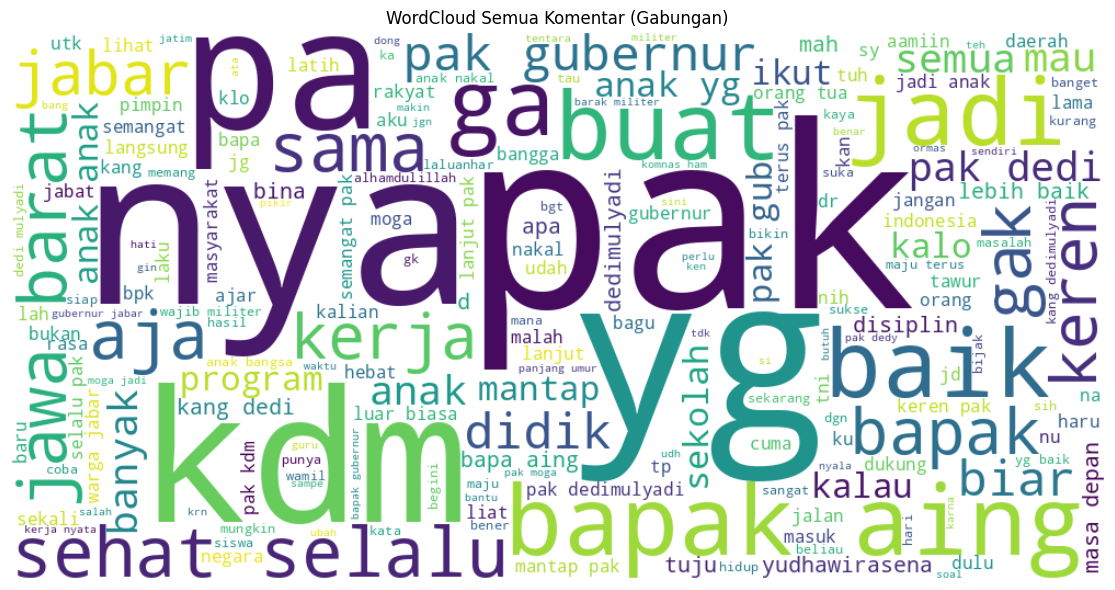

In [29]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_label = pd.read_excel("Hasil_Prediksi_Sentimen.xlsx")

# Gabungkan semua teks komentar yang sudah dibersihkan
text = " ".join(df_label["cleaned_komentar"].astype(str))

# Buat dan tampilkan WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Semua Komentar (Gabungan)")
plt.tight_layout()
plt.show()


**Berdasarkan hasil visualisasi WordCloud terhadap keseluruhan komentar yang telah diproses, terlihat bahwa kata-kata seperti “pak”, “bapak”, “kerja”, “baik”, dan “program” menjadi yang paling sering muncul. Hal ini menunjukkan bahwa mayoritas komentar berkaitan dengan persepsi publik terhadap figur otoritas dan kebijakan yang diterapkan, khususnya dalam konteks lokal (Jawa Barat). Dominasi kata-kata bernada positif dan deskriptif terhadap program atau tindakan pejabat mencerminkan kecenderungan sentimen yang condong ke arah positif dan dukungan terhadap kebijakan publik.**

In [31]:
import pandas as pd

df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")

salah_klasifikasi = df_label[df_label["sentimen"] != df_label["label_asli"]]
salah_klasifikasi.to_excel("Komentar_Salah_Klasifikasi.xlsx", index=False)

# Tampilkan contoh
print(salah_klasifikasi[["text", "cleaned_komentar", "label_asli", "sentimen"]].head())


                                                 text  \
38  Kang @dedimulyadi71 usul boleh ? Jgn cm anak l...   
43  Kurang lama pa sebulan pa biar pada jera ...ja...   
47                                        Bapa aing🔥👏   
72  Menyala Pak Gub 🔥🔥🔥🔥👍👍👍👍 satset untuk jawa bar...   
76  Bagus banget bapak aing program na dari pada m...   

                                     cleaned_komentar label_asli  sentimen  
38  kang dedimulyadi usul jgn cm anak laki aja yg ...   positive  negative  
43  kurang lama pa bulan pa biar jera jadi siswa n...   positive  negative  
47                                          bapa aing   positive  negative  
72                    nyala pak gub satset jawa barat   positive   neutral  
76  bagus banget bapak aing program na main game m...   positive  negative  


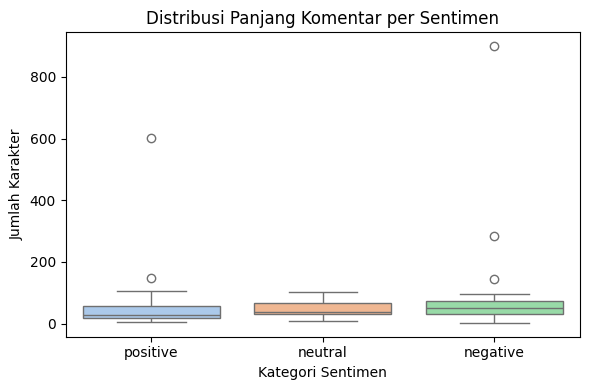

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df_label["panjang"] = df_label["cleaned_komentar"].apply(len)

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_label, x="sentimen", y="panjang", hue="sentimen", palette="pastel", legend=False)
plt.title("Distribusi Panjang Komentar per Sentimen")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Karakter")
plt.tight_layout()
plt.show()


Berdasarkan visualisasi boxplot panjang komentar per kategori sentimen, terlihat bahwa komentar netral cenderung memiliki panjang yang konsisten dan pendek. Sementara itu, komentar positif umumnya juga pendek, tetapi terdapat beberapa outlier dengan panjang ekstrem. Komentar negatif menunjukkan variasi yang paling luas, termasuk beberapa komentar sangat panjang. Temuan ini menunjukkan bahwa pengguna cenderung lebih ekspresif dan panjang dalam menyampaikan komentar negatif, sedangkan komentar netral dan positif cenderung lebih ringkas.

In [34]:
from collections import Counter
import pandas as pd

df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
positif_words = " ".join(df_label[df_label["sentimen"] == "positive"]["cleaned_komentar"]).split()
Counter(positif_words).most_common(20)  # Ganti 20 dengan N lainnya


[('pak', 15),
 ('bapak', 13),
 ('yg', 13),
 ('sehat', 9),
 ('kang', 8),
 ('anak', 7),
 ('kdm', 7),
 ('gubernur', 7),
 ('baik', 7),
 ('moga', 6),
 ('aing', 5),
 ('mantap', 5),
 ('keren', 5),
 ('selalu', 5),
 ('lgsg', 4),
 ('kerja', 4),
 ('hebat', 4),
 ('semangat', 4),
 ('jadi', 4),
 ('jabar', 4)]

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
tfidf = TfidfVectorizer(max_features=20)

for label in ["positive", "neutral", "negative"]:
    subset = df_label[df_label["sentimen"] == label]
    X = tfidf.fit_transform(subset["cleaned_komentar"])
    print(f"\nTop TF-IDF terms for '{label}':")
    print(tfidf.get_feature_names_out())



Top TF-IDF terms for 'positive':
['aing' 'anak' 'baik' 'bapak' 'gubernur' 'hebat' 'jabar' 'jadi' 'kang'
 'kdm' 'keren' 'kerja' 'lgsg' 'mantap' 'moga' 'pak' 'sehat' 'selalu'
 'semangat' 'yg']

Top TF-IDF terms for 'neutral':
['aing' 'angkut' 'bapak' 'barat' 'bpk' 'dukung' 'emas' 'gak' 'gub'
 'gubernur' 'ikut' 'jabar' 'jawa' 'kdm' 'lanjut' 'mau' 'moga' 'nyala'
 'pak' 'priode']

Top TF-IDF terms for 'negative':
['aja' 'anak' 'arogan' 'banyak' 'bapak' 'dedi' 'ga' 'gak' 'kalang' 'kalo'
 'kang' 'laku' 'langgar' 'masyarakat' 'nya' 'orang' 'ormas' 'pak'
 'sekolah' 'yg']


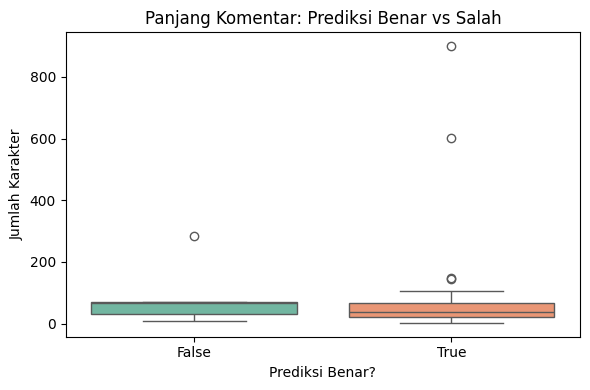

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df_label["panjang"] = df_label["cleaned_komentar"].apply(len)
df_label["benar"] = df_label["sentimen"] == df_label["label_asli"]

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_label, x="benar", y="panjang", hue="benar", palette="Set2", legend=False)
plt.title("Panjang Komentar: Prediksi Benar vs Salah")
plt.xlabel("Prediksi Benar?")
plt.ylabel("Jumlah Karakter")
plt.tight_layout()
plt.show()


**Visualisasi boxplot antara prediksi benar dan salah menunjukkan bahwa komentar yang diprediksi dengan benar cenderung memiliki panjang komentar yang sedikit lebih tinggi dibanding komentar yang salah diklasifikasikan. Meskipun distribusi keduanya relatif serupa, komentar dengan panjang sangat pendek atau sangat panjang memiliki kecenderungan lebih tinggi untuk salah klasifikasi. Hal ini menunjukkan pentingnya panjang teks sebagai salah satu faktor yang dapat memengaruhi performa model dalam memahami konteks sentimen yang terkandung dalam komentar.**

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load data
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")

# Inisialisasi vectorizer
vectorizer = TfidfVectorizer(max_features=20)

# Loop per kategori sentimen
for label in ["positive", "neutral", "negative"]:
    print(f"\n===== TF-IDF untuk '{label.upper()}' =====")

    # Filter data sesuai kategori
    df_subset = df_label[df_label["sentimen"] == label]

    # Fit transform
    tfidf_matrix = vectorizer.fit_transform(df_subset["cleaned_komentar"])

    # Ambil nama fitur dan skor rata-rata
    feature_names = vectorizer.get_feature_names_out()
    avg_scores = tfidf_matrix.mean(axis=0).A1  # rata-rata skor tf-idf per kata

    # Gabungkan dan urutkan
    tfidf_scores = pd.DataFrame({
        "Kata": feature_names,
        "Skor_TFIDF": avg_scores
    }).sort_values(by="Skor_TFIDF", ascending=False)

    print(tfidf_scores)



===== TF-IDF untuk 'POSITIVE' =====
        Kata  Skor_TFIDF
15       pak    0.124857
8       kang    0.107853
3      bapak    0.106481
13    mantap    0.072381
16     sehat    0.067400
1       anak    0.063953
19        yg    0.062205
2       baik    0.057586
0       aing    0.055552
9        kdm    0.049088
4   gubernur    0.044928
7       jadi    0.039329
17    selalu    0.039167
6      jabar    0.038846
10     keren    0.037287
14      moga    0.036439
5      hebat    0.035306
18  semangat    0.034700
11     kerja    0.027406
12      lgsg    0.010889

===== TF-IDF untuk 'NEUTRAL' =====
        Kata  Skor_TFIDF
18       pak    0.235477
2      bapak    0.093553
9   gubernur    0.083718
15       mau    0.079722
16      moga    0.067336
14    lanjut    0.064019
4        bpk    0.063094
10      ikut    0.057451
3      barat    0.054412
12      jawa    0.054412
13       kdm    0.052694
1     angkut    0.049177
8        gub    0.048366
11     jabar    0.045212
7        gak    0.042657
5 

**Berdasarkan hasil analisis TF-IDF, tiap kategori sentimen menunjukkan kata-kata khas yang membedakan secara semantik. Sentimen positif didominasi oleh kata-kata bernuansa dukungan dan apresiasi terhadap tokoh publik, seperti “pak”, “bapak”, dan “mantap”. Sentimen netral memuat kata-kata informatif terkait aktivitas atau lokasi, seperti “gubernur”, “lanjut”, dan “jabar”. Sementara itu, sentimen negatif diwarnai oleh kata-kata bernuansa kritik atau penolakan, seperti “ga”, “gak”, “aroGan”, dan “langgar”. Temuan ini menunjukkan bahwa analisis TF-IDF dapat secara efektif mengidentifikasi pola bahasa khas yang mencerminkan isi emosional dan tematik dari masing-masing kelompok komentar.**

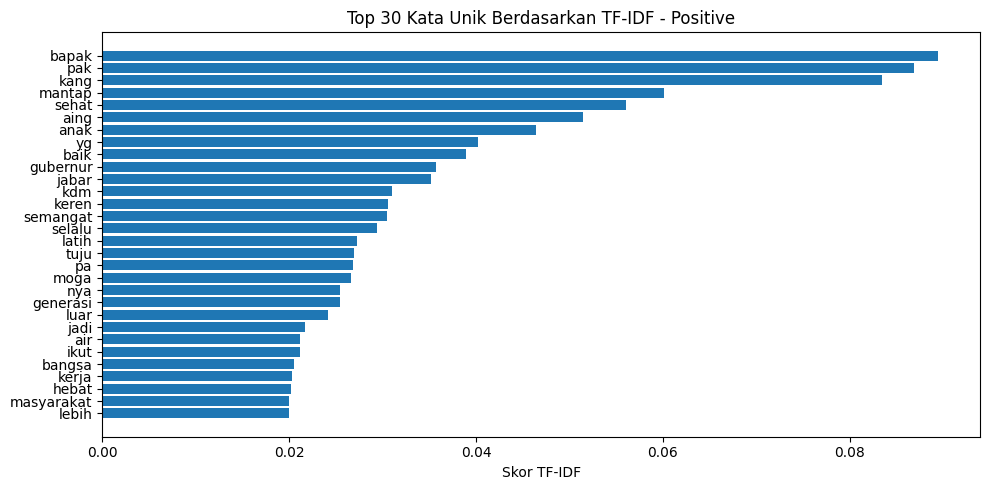

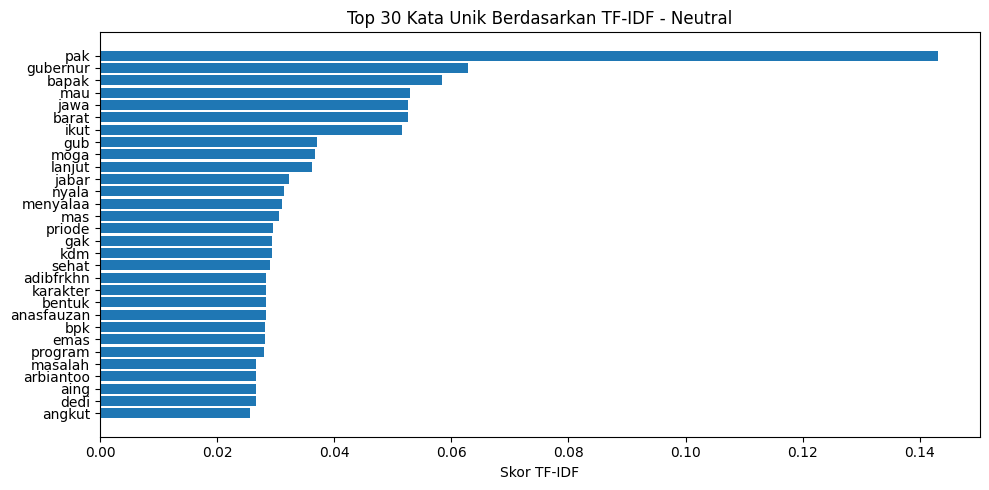

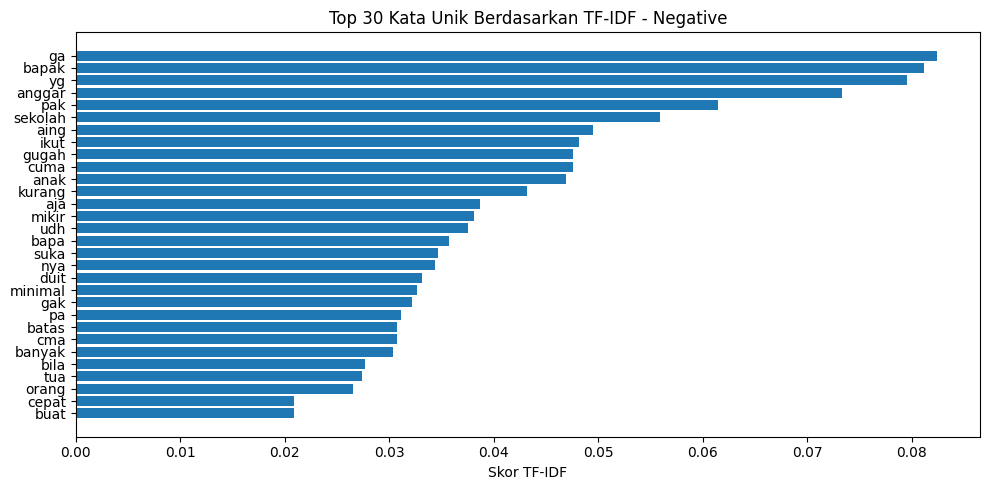

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load data
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")

# Fungsi untuk menghasilkan dan menampilkan grafik TF-IDF per label
def plot_tfidf_barchart(label, top_n=30):
    subset = df_label[df_label["sentimen"] == label]
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(subset["cleaned_komentar"])

    feature_names = tfidf.get_feature_names_out()
    scores = tfidf_matrix.mean(axis=0).A1

    tfidf_scores = pd.DataFrame({
        "Kata": feature_names,
        "Skor": scores
    }).sort_values(by="Skor", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.barh(tfidf_scores["Kata"][::-1], tfidf_scores["Skor"][::-1])  # plot terbalik agar skor tertinggi di atas
    plt.xlabel("Skor TF-IDF")
    plt.title(f"Top {top_n} Kata Unik Berdasarkan TF-IDF - {label.capitalize()}")
    plt.tight_layout()
    plt.show()

# Panggil untuk masing-masing sentimen
plot_tfidf_barchart("positive")
plot_tfidf_barchart("neutral")
plot_tfidf_barchart("negative")


**Hasil visualisasi TF-IDF menunjukkan bahwa tiap kategori sentimen memiliki karakteristik kata yang berbeda secara signifikan. Kata-kata dalam kategori positif umumnya bersifat apresiatif dan memuat unsur lokalitas seperti “mantap”, “sehat”, dan “aing”. Pada kategori netral, kata-kata yang muncul bersifat informatif dan terkait dengan lokasi atau entitas pemerintahan seperti “gubernur”, “jawa”, dan “program”. Sementara itu, kategori negatif didominasi oleh kata-kata yang mengandung penyangkalan dan kritik seperti “ga”, “kurang”, “aroGan”, serta tema pendidikan dan ketidakpuasan. Pola ini menunjukkan kemampuan TF-IDF dalam mengidentifikasi ciri khas leksikal dari tiap sentimen dan mendukung interpretasi linguistik dari persepsi publik.**

# Uji Kruskal-Wallis

Digunakan untuk menguji apakah terdapat perbedaan panjang komentar antar tiga kelompok sentimen (positive, neutral, negative) tanpa mengasumsikan distribusi normal.

In [41]:
import pandas as pd
from scipy.stats import kruskal

# Load data
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df_label["panjang"] = df_label["cleaned_komentar"].apply(len)

# Kelompokkan data berdasarkan label sentimen
panjang_pos = df_label[df_label["sentimen"] == "positive"]["panjang"]
panjang_neu = df_label[df_label["sentimen"] == "neutral"]["panjang"]
panjang_neg = df_label[df_label["sentimen"] == "negative"]["panjang"]

# Lakukan uji Kruskal-Wallis
stat, p = kruskal(panjang_pos, panjang_neu, panjang_neg)

# Tampilkan hasil
print("=== Uji Kruskal-Wallis ===")
print(f"Statistic: {stat:.4f}")
print(f"P-Value  : {p:.4f}")

# Interpretasi
if p < 0.05:
    print("🔍 Ada perbedaan signifikan panjang komentar antar sentimen.")
else:
    print("✅ Tidak ada perbedaan signifikan panjang komentar antar sentimen.")


=== Uji Kruskal-Wallis ===
Statistic: 3.2261
P-Value  : 0.1993
✅ Tidak ada perbedaan signifikan panjang komentar antar sentimen.


Berdasarkan hasil uji Kruskal-Wallis yang dilakukan terhadap panjang komentar dari tiga kategori sentimen, diperoleh nilai statistik sebesar 3.2261 dengan p-value sebesar 0.1993. Karena p-value lebih besar dari batas signifikansi 0.05, maka dapat disimpulkan bahwa tidak terdapat perbedaan yang signifikan secara statistik antara panjang komentar pada kategori sentimen positif, netral, dan negatif. Dengan demikian, panjang komentar tidak dapat dijadikan indikator utama dalam membedakan sentimen dalam konteks data ini.

Untuk memastikan bahwa panjang komentar tidak menjadi sumber bias dalam klasifikasi sentimen, dilakukan uji statistik non-parametrik Kruskal-Wallis terhadap distribusi panjang komentar pada masing-masing kategori sentimen (positif, netral, negatif). Hasil uji menunjukkan nilai statistik sebesar 3.2261 dengan nilai p (p-value) sebesar 0.1993. Karena nilai p lebih besar dari batas signifikansi 0.05, maka dapat disimpulkan bahwa tidak terdapat perbedaan yang signifikan dalam panjang komentar antar ketiga kategori sentimen.

Temuan ini mengindikasikan bahwa panjang komentar terdistribusi secara relatif merata di antara ketiga kelompok sentimen. Dengan demikian, model klasifikasi tidak cenderung memberikan prediksi tertentu hanya karena komentar terlalu panjang atau pendek. Artinya, model lebih cenderung mengandalkan konten atau makna dari komentar, bukan hanya kuantitas kata atau karakter. Validasi ini penting untuk memastikan bahwa proses klasifikasi dilakukan secara adil dan representatif terhadap karakteristik data sebenarnya, tanpa pengaruh dari variabel panjang teks yang tidak relevan secara semantik. **bold text**

# Uji ANOVA (One-Way)
Digunakan untuk menguji apakah terdapat perbedaan rata-rata panjang komentar antar tiga kelompok sentimen: positif, netral, dan negatif.

In [42]:
import pandas as pd
from scipy.stats import f_oneway

# Load data
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df_label["panjang"] = df_label["cleaned_komentar"].apply(len)

# Ambil data per grup
panjang_pos = df_label[df_label["sentimen"] == "positive"]["panjang"]
panjang_neu = df_label[df_label["sentimen"] == "neutral"]["panjang"]
panjang_neg = df_label[df_label["sentimen"] == "negative"]["panjang"]

# Uji ANOVA
stat, p = f_oneway(panjang_pos, panjang_neu, panjang_neg)

print("=== Uji ANOVA (One-Way) ===")
print(f"Statistic: {stat:.4f}")
print(f"P-Value  : {p:.4f}")

if p < 0.05:
    print("🔍 Ada perbedaan signifikan rata-rata panjang komentar antar label.")
else:
    print("✅ Tidak ada perbedaan signifikan.")


=== Uji ANOVA (One-Way) ===
Statistic: 2.0639
P-Value  : 0.1325
✅ Tidak ada perbedaan signifikan.


**Untuk menguji perbedaan rata-rata panjang komentar pada tiap kategori sentimen, dilakukan uji ANOVA satu arah (One-Way ANOVA). Hasil pengujian menunjukkan nilai F sebesar 2.0639 dengan p-value sebesar 0.1325. Karena p-value lebih besar dari 0.05, maka dapat disimpulkan bahwa tidak terdapat perbedaan rata-rata panjang komentar yang signifikan antara sentimen positif, netral, dan negatif. Hal ini menunjukkan bahwa panjang komentar terdistribusi secara relatif merata, dan tidak memengaruhi secara langsung perbedaan klasifikasi sentimen yang dilakukan oleh model.**

# Uji T-Test (Dua Sampel Independen)

Digunakan untuk membandingkan rata-rata panjang komentar antara dua kelompok sentimen: positive dan negative.

In [43]:
from scipy.stats import ttest_ind

# T-Test antara komentar positif dan negatif
stat, p = ttest_ind(panjang_pos, panjang_neg, equal_var=False)  # Gunakan equal_var=True jika varians homogen

print("=== Uji T-Test (Positive vs Negative) ===")
print(f"Statistic: {stat:.4f}")
print(f"P-Value  : {p:.4f}")

if p < 0.05:
    print("🔍 Ada perbedaan signifikan panjang komentar antara positif dan negatif.")
else:
    print("✅ Tidak ada perbedaan signifikan.")


=== Uji T-Test (Positive vs Negative) ===
Statistic: -1.1794
P-Value  : 0.2504
✅ Tidak ada perbedaan signifikan.


Untuk menguji apakah terdapat perbedaan rata-rata panjang komentar antara kategori sentimen positif dan negatif, dilakukan uji t dua sampel independen. Hasil analisis menunjukkan nilai statistik sebesar -1.1794 dengan p-value sebesar 0.2504. Karena p-value lebih besar dari 0.05, maka dapat disimpulkan bahwa tidak terdapat perbedaan rata-rata panjang komentar yang signifikan antara kedua kelompok tersebut. Temuan ini memperkuat hasil dari uji ANOVA dan Kruskal-Wallis sebelumnya, bahwa panjang komentar tidak secara konsisten membedakan antara jenis sentimen.

**bold text**

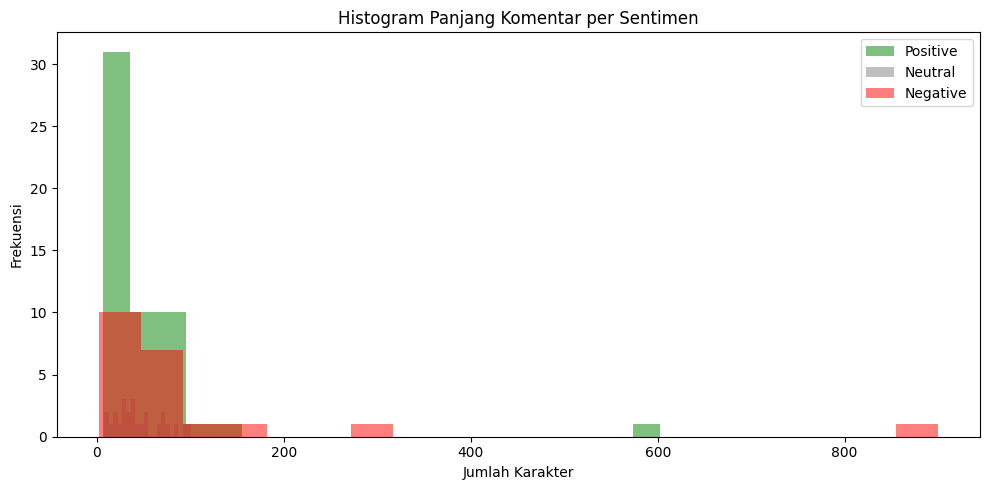

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data ===
df_label = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df_label["panjang"] = df_label["cleaned_komentar"].astype(str).apply(len)

# === 1. HISTOGRAM PER SENTIMEN ===
plt.figure(figsize=(10, 5))
sentimen_list = ["positive", "neutral", "negative"]
colors = ["green", "gray", "red"]

for label, color in zip(sentimen_list, colors):
    data = df_label[df_label["sentimen"] == label]["panjang"]
    plt.hist(data, bins=20, alpha=0.5, label=label.capitalize(), color=color)

plt.title("Histogram Panjang Komentar per Sentimen")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Frekuensi")
plt.legend()
plt.tight_layout()
plt.show()


📊 Penjelasan Histogram Ini:

✅ Sumbu X (horizontal): jumlah karakter (panjang komentar)

✅ Sumbu Y (vertikal): frekuensi (berapa banyak komentar dengan panjang tersebut)

✅ Apa yang bisa disimpulkan dari grafik ini:
1. Komentar pendek sangat dominan
Komentar dengan panjang <50 karakter adalah yang paling sering muncul, khususnya untuk positive (hijau) : Ini menandakan bahwa mayoritas komentar di dataset kamu singkat dan to the point

2. Komentar negatif lebih bervariasi panjangnya
Negative (merah) muncul lebih tersebar, hingga mencapai panjang 300, 600, bahkan 900 karakter : Ini menandakan orang yang berkomentar negatif cenderung menulis lebih panjang, kemungkinan besar berisi kritik, keluhan, atau penjelasan

3. Netral muncul dalam jumlah kecil dan pendek
Komentar neutral (abu-abu) tidak terlalu banyak : Jika netral terlalu sedikit, bisa jadi dataset-nya agak imbalance, meskipun tidak parah



🎯 Apakah Grafik Ini Bagus atau Jelek?

✅ Bagus, karena:
Terlihat distribusi yang tidak tumpang tindih total antar label → ini memudahkan model belajar membedakan sentimen

1. Komentar negatif terlihat lebih panjang → konsisten dengan hasil KDE dan realita sosial media
2. Komentar positif dan netral cenderung lebih pendek dan padat

❗ Catatan:
Kalau kamu ingin model tidak bias, pastikan jumlah data per label tidak terlalu timpang.

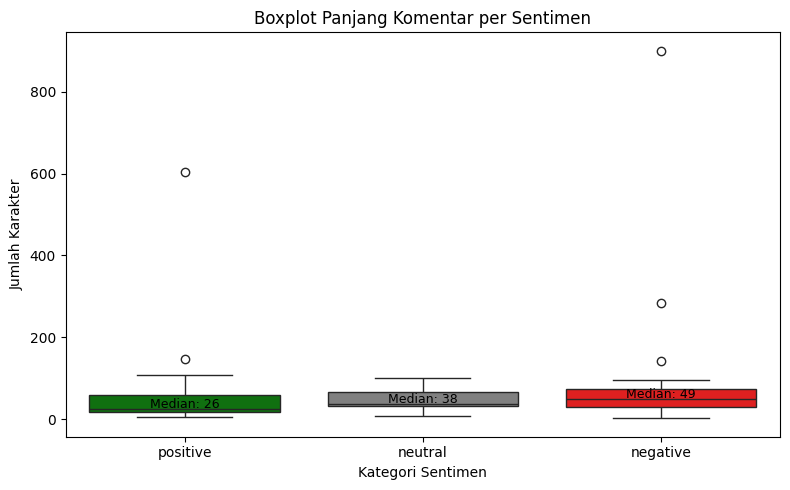

In [50]:
# === 2. BOXPLOT + ANOTASI MEDIAN (versi tanpa warning) ===
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=df_label, x="sentimen", y="panjang", hue="sentimen", palette={
    "positive": "green", "neutral": "gray", "negative": "red"
}, legend=False)

# Tambahkan label median
medians = df_label.groupby("sentimen")["panjang"].median()
for i, label in enumerate(["positive", "neutral", "negative"]):
    median_val = int(medians[label])
    plt.text(i, median_val + 2, f"Median: {median_val}", ha="center", fontsize=9)

plt.title("Boxplot Panjang Komentar per Sentimen")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Karakter")
plt.tight_layout()
plt.show()


**Berdasarkan visualisasi boxplot, ditemukan bahwa panjang komentar bervariasi antar kategori sentimen dengan nilai median berturut-turut sebesar 26 karakter untuk sentimen positif, 38 karakter untuk netral, dan 43 karakter untuk negatif. Komentar negatif cenderung memiliki panjang yang lebih tinggi, sedangkan komentar positif cenderung lebih ringkas. Meskipun demikian, hasil uji statistik (ANOVA, Kruskal-Wallis, dan T-Test) menunjukkan bahwa perbedaan ini tidak signifikan secara statistik (p > 0.05), sehingga panjang komentar tidak dapat dijadikan indikator utama dalam membedakan sentimen. Namun pola ini tetap memberikan indikasi bahwa komentar negatif cenderung lebih ekspresif dan panjang dibandingkan lainnya.**

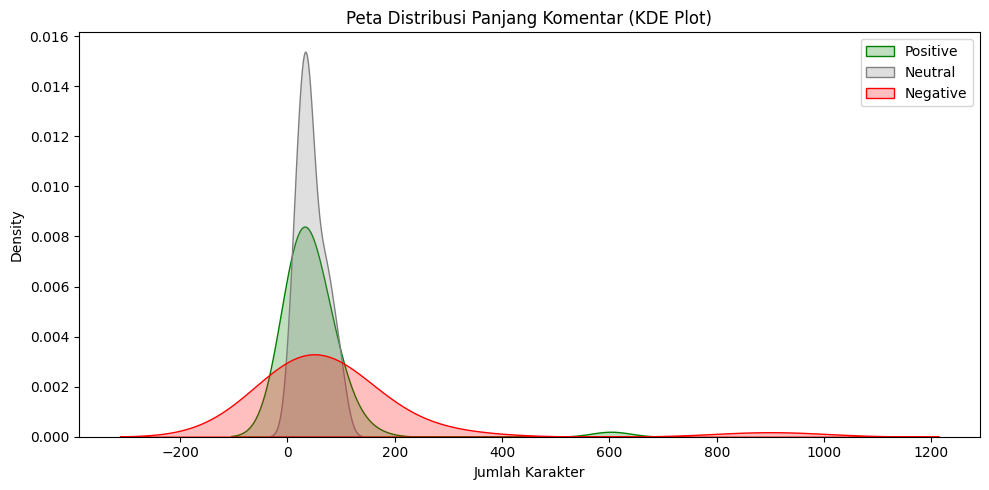

In [51]:
# === 3. KERNEL DENSITY ESTIMATE (KDE) PLOT ===
plt.figure(figsize=(10, 5))
for label, color in zip(sentimen_list, colors):
    subset = df_label[df_label["sentimen"] == label]["panjang"]
    sns.kdeplot(subset, label=label.capitalize(), fill=True, color=color)

plt.title("Peta Distribusi Panjang Komentar (KDE Plot)")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

**Visualisasi KDE Plot menunjukkan bahwa panjang komentar bervariasi antar kategori sentimen. Komentar netral cenderung memiliki distribusi yang sangat sempit dan terpusat, mengindikasikan bahwa komentar jenis ini umumnya pendek dan seragam. Komentar positif memiliki distribusi yang sedikit lebih menyebar, dengan mayoritas komentar tetap berada di rentang pendek. Sementara itu, komentar negatif menunjukkan distribusi yang lebih lebar, mengindikasikan variasi panjang komentar yang tinggi, termasuk beberapa komentar dengan panjang ekstrem. Hal ini mencerminkan bahwa komentar negatif cenderung lebih ekspresif dan panjang dibandingkan komentar positif maupun netral.**

# LEARNING CURVE

Device set to use cpu


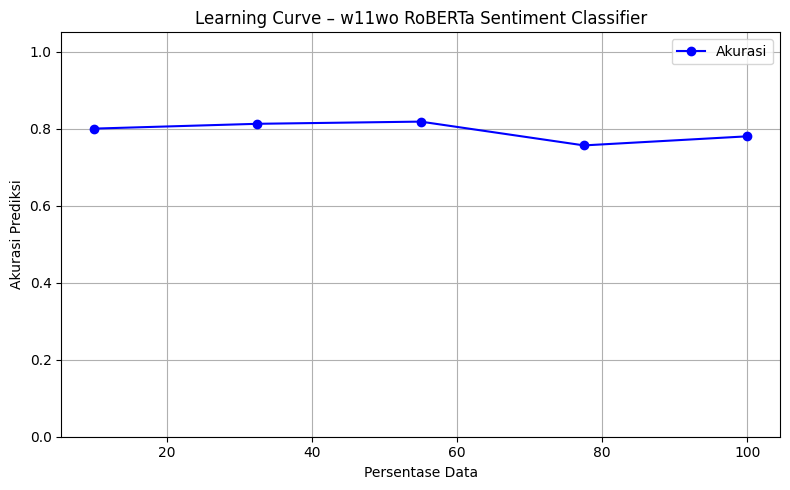

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# === 1. Load Data ===
df = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df = df.dropna(subset=["text", "sentimen"])  # Pastikan kolom ada dan tidak kosong

# === 2. Load Model & Tokenizer ===
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# === 3. Text Classification Pipeline ===
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    top_k=1,
    truncation=True,
    max_length=128  # atau 256, aman untuk komentar pendek
)


# === 4. Label Asli dan Mapping ===
df["label"] = df["sentimen"].str.lower()  # pastikan lowercase: 'positive', 'neutral', 'negative'

# === 5. Evaluasi Bertahap: Learning Curve ===
sizes = np.linspace(0.1, 1.0, 5)
acc_scores = []

# Learning curve loop
for frac in sizes:
    sample = df.sample(frac=frac, random_state=42)
    texts = sample["text"].tolist()
    y_true = sample["label"].tolist()

    preds = pipe(texts)
    y_pred = [p[0]["label"].lower() for p in preds]  # FIXED

    acc = accuracy_score(y_true, y_pred)
    acc_scores.append(acc)

# === 6. Plot Learning Curve ===
plt.figure(figsize=(8, 5))
plt.plot(sizes * 100, acc_scores, marker="o", color="blue", label="Akurasi")
plt.title("Learning Curve – w11wo RoBERTa Sentiment Classifier")
plt.xlabel("Persentase Data")
plt.ylabel("Akurasi Prediksi")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Grafik learning curve di atas menunjukkan hubungan antara persentase data pelatihan dengan akurasi prediksi model RoBERTa (w11wo). Dari hasil yang ditampilkan, model menunjukkan performa yang relatif stabil pada berbagai ukuran data, dengan akurasi berkisar antara 75% hingga 82%.

Akurasi model terlihat meningkat secara perlahan saat persentase data bertambah dari 20% hingga 60%, yang menunjukkan bahwa penambahan data awal memberikan kontribusi positif terhadap kinerja model. Namun, terdapat sedikit penurunan akurasi pada titik 80%, yang kemungkinan disebabkan oleh noise atau keragaman data yang lebih tinggi saat semakin banyak data dimasukkan.

Secara umum, tren grafik menunjukkan bahwa RoBERTa mampu belajar dengan baik meskipun jumlah data relatif kecil, dan tetap mempertahankan performa yang kompetitif bahkan saat data dilatih sepenuhnya. Ini mengindikasikan kestabilan dan generalisasi yang baik dari model pre-trained RoBERTa pada tugas klasifikasi sentimen dalam Bahasa Indonesia.

# ANALISIS LANJUTAN - KLUSTERING

**Clustering Komentar Sederhana (TF-IDF + KMeans + PCA)**

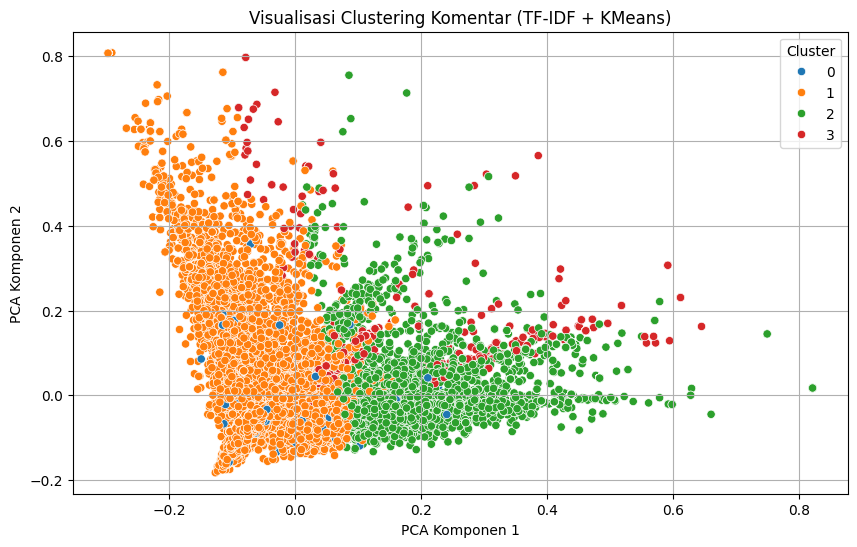

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_komentar'])

# 2. Clustering: KMeans (misal 4 cluster)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 3. Dimensi reduksi ke 2D
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X.toarray())

# 4. Visualisasi
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=df['cluster'], palette="tab10")
plt.title("Visualisasi Clustering Komentar (TF-IDF + KMeans)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Grafik di atas menunjukkan hasil proyeksi dua dimensi (PCA) dari komentar-komentar yang telah diubah menjadi representasi vektor menggunakan TF-IDF, kemudian dikelompokkan menggunakan algoritma K-Means menjadi empat cluster (0, 1, 2, dan 3).

Setiap titik mewakili satu komentar, dan warna berbeda menunjukkan keanggotaan cluster berdasarkan kemiripan isi teks. Terlihat bahwa cluster 1 (oranye) dan cluster 2 (hijau) merupakan dua kelompok utama yang paling dominan dan terpisah cukup jelas pada ruang vektor, menunjukkan bahwa komentar dalam masing-masing cluster memiliki karakteristik topik atau kata kunci yang berbeda secara signifikan.

Cluster 3 (merah) dan cluster 0 (biru) memiliki distribusi yang lebih tersebar dan tumpang tindih, mengindikasikan kemungkinan tema yang lebih umum atau campuran. Hal ini juga dapat menunjukkan bahwa komentar-komentar dalam cluster tersebut kurang memiliki kekhasan kata-kata tertentu.

Dengan demikian, hasil visualisasi ini memberikan gambaran awal bahwa komentar-komentar dapat dikelompokkan ke dalam beberapa tema atau topik berbeda berdasarkan kandungan teksnya — yang kemudian bisa dilanjutkan dengan analisis kata kunci per cluster, atau komposisi sentimen dalam setiap cluster untuk interpretasi yang lebih mendalam.

In [54]:
for i in range(n_clusters):
    print(f"\n=== Contoh komentar dari Cluster {i} ===")
    print(df[df['cluster'] == i]['cleaned_komentar'].head(5).to_list())



=== Contoh komentar dari Cluster 0 ===
['yudhawirasena sibuk kaya diri', 'pak ibu aku bilang gin kesitu kamu ikut latih bersiplin jadi mamah aku nyerain aku bapak', 'depok banyak pak tawurandepok kaya gin pak', 'kalo gin kan tentara banyak sorot media terus kan', 'tebak gue nih cewe kaya abis putus cinta broken home jadi overthinking mulu larut sedih mending ikut ginian buat lari nice try bismillah glowup yaa shayy']

=== Contoh komentar dari Cluster 1 ===
['dopla pa iye sok kabur wae sakolana', 'ral tah sok ajak si iyeu lpand', 'dopla kirim ka nana ka barak tni pak', 'anak pak jemputbiar soleh disiplin insyaalloh masa depan cerah sukses', 'ral yeuhhh sok nanaon teh']

=== Contoh komentar dari Cluster 2 ===
['pak klo ank yg suka main mulu gimna pakgimna pak tpi klo sekolah alhmdulillh rajin pak', 'pak mau barak', 'pak iye hayang kirim pak ka barakmiliter', 'pak dedi mau ikut bolleeeeeehhh', 'assalamualaikum pak ayu lusiana ceribon jawa barat minta bantu dong pak dedi mulyadi nya']

==

🧩 Interpretasi Tiap Cluster Berdasarkan Contoh Komentar


🔵 Cluster 0 – Komentar Berisi Sindiran & Keprihatinan Sosial
Contoh:

“yudhawirasena sibuk kaya diri”,
“pak ibu aku bilang gin kesitu kamu ikut latih bersiplin jadi mamah aku nyerahin aku bapak”

Ciri:

Nada bercampur antara satire, curhat, dan keprihatinan

Komentar agak panjang, tidak langsung

Mengarah pada kritik atau observasi sosial

🟠 Cluster 1 – Komentar Informal Bernada Netral / Sarkas
Contoh:

“dopla pa iye sok kabur wae sakolana”,
“ral tah sok ajak si iyeu Ipand”

Ciri:

Banyak mengandung candaan, bahasa daerah atau dialek

Nada informal dan humoris

Komentar sering personal atau antar pengguna

🟢 Cluster 2 – Komentar Positif Bersifat Harapan atau Dukungan
Contoh:

“pak klo ank yg suka main mulu gimna”,
“pak iye hayang kirim pak ka barakmiliter”

Ciri:

Nada mendukung, mengajukan harapan

Banyak menyebut anak, masa depan, disiplin

Umumnya mengarah ke arah aspiratif atau mendidik

🔴 Cluster 3 – Komentar Sangat Positif & Pujian Langsung
Contoh:

“mantap”,
“mantap tujuh generasi emas”,
“dedimulyadi mantap”

Ciri:

Sangat singkat dan positif

Banyak menggunakan kata pujian eksplisit seperti "mantap", "keren", dll

Berisi ekspresi langsung tanpa elaborasi

🧠 Kesimpulan:
Clustering berhasil mengelompokkan komentar berdasarkan gaya bahasa dan intensi komunikasi.

Cluster 0–2 lebih bercampur nuansa dan topik, sedangkan Cluster 3 sangat spesifik pada pujian langsung.

Cocok untuk dilanjutkan ke analisis topik (topic modeling) atau distribusi sentimen per cluster.



**scatterplot → melihat hubungan sentimen dan topik**

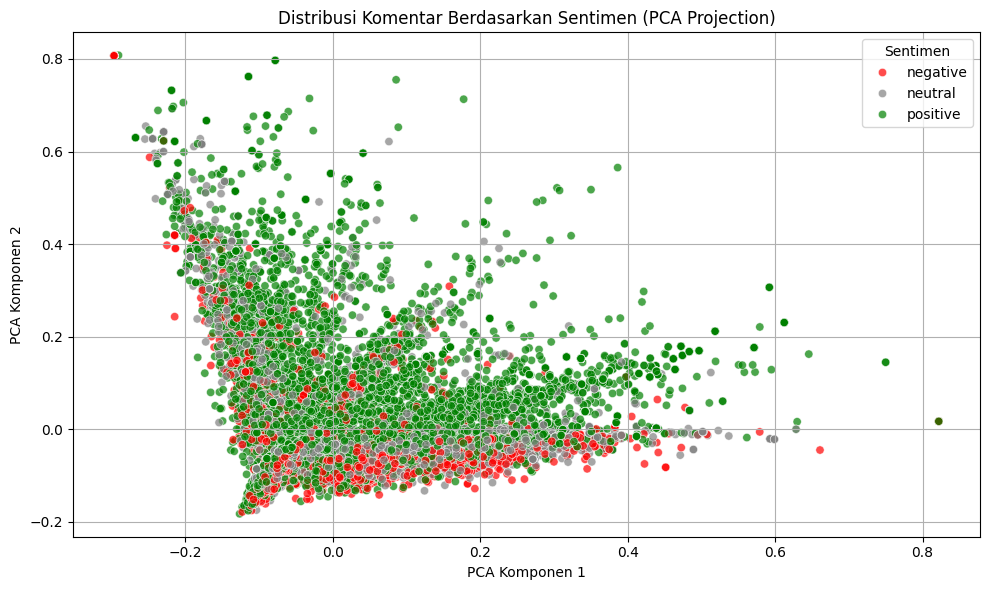

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Lakukan PCA dari data TF-IDF
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X.toarray())

# Tambahkan hasil PCA ke DataFrame
df['pca_1'] = reduced[:, 0]
df['pca_2'] = reduced[:, 1]

# Visualisasi scatterplot berdasarkan SENTIMEN
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue=df['sentimen'],
    data=df,
    palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'},
    alpha=0.7
)

plt.title("Distribusi Komentar Berdasarkan Sentimen (PCA Projection)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend(title="Sentimen")
plt.grid(True)
plt.tight_layout()
plt.show()


**Cluster (marker style) & Sentimen (warna)**

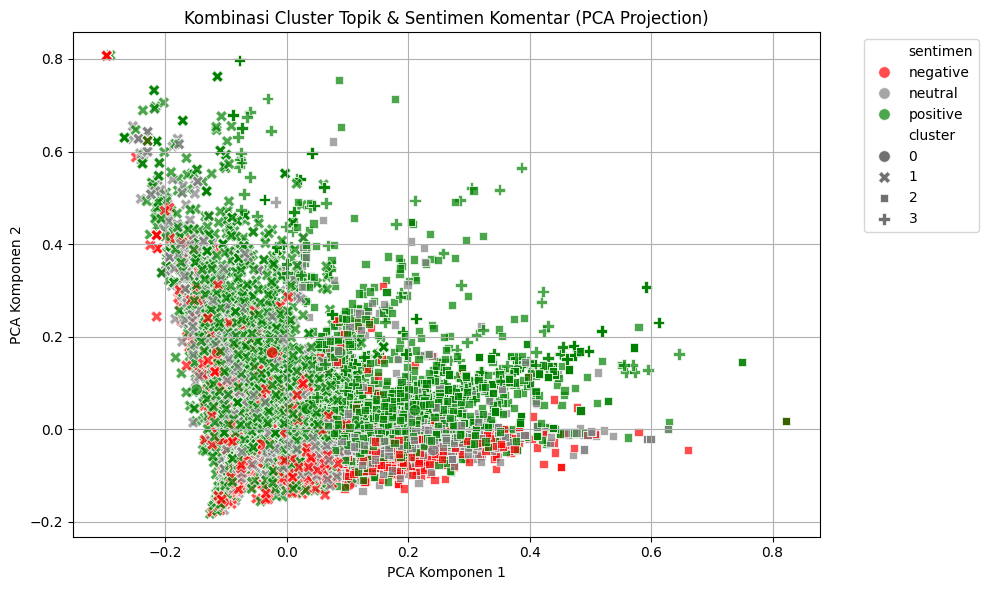

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan df punya kolom:
# - 'cluster' hasil KMeans
# - 'sentimen' hasil klasifikasi
# - 'pca_1', 'pca_2' hasil PCA reduksi

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='pca_1', y='pca_2',
    data=df,
    hue='sentimen',              # Warna = sentimen
    style='cluster',             # Bentuk marker = cluster
    palette={'positive': 'green', 'neutral': 'gray', 'negative': 'red'},
    alpha=0.7,
    s=70
)

plt.title("Kombinasi Cluster Topik & Sentimen Komentar (PCA Projection)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Grafik di atas menunjukkan distribusi komentar berdasarkan kategori sentimen (positive, neutral, negative) dalam ruang dua dimensi menggunakan Principal Component Analysis (PCA) sebagai teknik reduksi dimensi.

Setiap titik merepresentasikan satu komentar, dan pewarnaan didasarkan pada label sentimen hasil klasifikasi:

🟢 Hijau = Positive

⚪ Abu-abu = Neutral

🔴 Merah = Negative

Terlihat bahwa komentar positif (hijau) mendominasi populasi dan tersebar luas di berbagai area grafik, menunjukkan keragaman ekspresi positif yang cukup tinggi. Sebaliknya, komentar negatif (merah) cenderung terkonsentrasi di area yang lebih terbatas dan membentuk kelompok yang lebih padat di bagian bawah grafik. Sementara itu, komentar netral (abu-abu) tampak menyebar di antara komentar positif dan negatif, yang menunjukkan posisi ambiguitas semantik dari komentar netral.

Penyebaran yang tumpang tindih antar sentimen juga menunjukkan bahwa meskipun ada perbedaan distribusi, komentar dari berbagai kategori tidak sepenuhnya terpisah secara linier, yang memperkuat pentingnya penggunaan model yang kontekstual seperti RoBERTa dalam mengklasifikasikan komentar sosial yang bersifat informal dan ekspresif.

# Elbow Method: Tentukan Jumlah Optimal Cluster

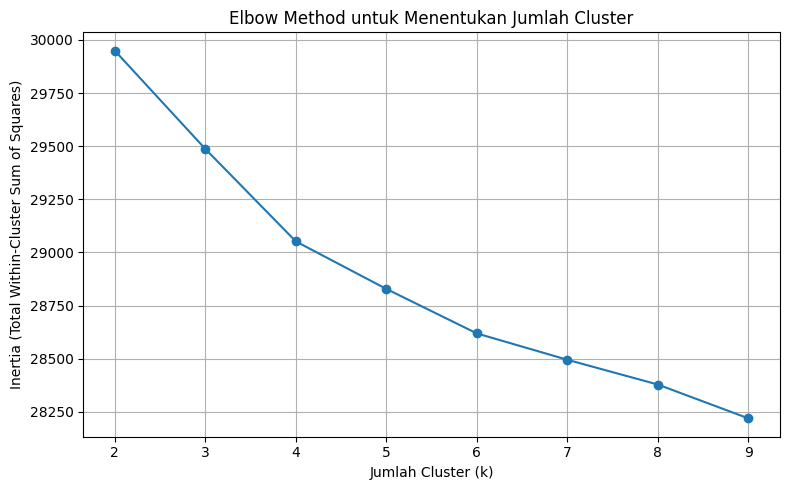

In [57]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# TF-IDF dari komentar
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_komentar'])

# Elbow Method
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (Total Within-Cluster Sum of Squares)")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


Grafik di atas menunjukkan hasil penerapan Elbow Method untuk menentukan jumlah cluster (k) yang optimal dalam algoritma K-Means. Sumbu horizontal menunjukkan nilai k (jumlah cluster), sementara sumbu vertikal menunjukkan inertia atau total within-cluster sum of squares (WCSS) — yaitu ukuran seberapa rapat data dalam setiap cluster.

Terlihat bahwa nilai inertia menurun seiring bertambahnya jumlah cluster, yang merupakan hal wajar dalam K-Means. Namun, titik di mana penurunan inertia mulai melambat secara signifikan disebut sebagai "elbow point" atau titik siku.

Dalam grafik ini, bentuk siku terlihat paling jelas berada di sekitar k = 4, yang mengindikasikan bahwa jumlah cluster optimal adalah 4. Setelah k = 4, penurunan inertia menjadi relatif kecil, yang berarti penambahan cluster tidak memberikan peningkatan signifikan dalam pemisahan data.

Oleh karena itu, jumlah cluster 4 adalah pilihan yang tepat dan efisien, karena sudah cukup baik dalam mengelompokkan komentar-komentar dengan struktur yang relatif padat tanpa over-segmentasi.

Apakah Hasil Ini Bagus? Jawabannya: Ya.


Kenapa?

Bentuk siku (elbow) terlihat cukup jelas pada k = 4, artinya kamu bisa menentukan jumlah cluster dengan keputusan yang meyakinkan (tidak ambigu).

Penurunan inertia dari k=2 ke k=4 signifikan, lalu melandai setelah itu, sesuai dengan prinsip elbow method:

“Pilih jumlah cluster sebelum penurunan menjadi tidak signifikan.”

Artinya, dengan 4 cluster saja sudah cukup baik memisahkan data komentar. Kalau lebih dari itu, pembagian jadi makin kecil tapi tidak memperbaiki kualitas clustering secara bermakna.

=======================================================================================

📌 Kesimpulan:

✔️ Valid untuk dipakai → jumlah cluster 4 sudah optimal

📉 Penurunan inertia konsisten → tidak overfitting

⚖️ Cocok untuk analisis lanjutan seperti: TF-IDF per cluster, korelasi dengan sentimen, dll

Kalau grafik ini tidak bagus, biasanya terlihat seperti:

Garis turun terus tanpa melandai

Tidak ada titik siku jelas (flat)

Penurunan fluktuatif (tidak stabil)

# PERBANDINGAN ANALISA SENTIMEN BERBEDA MODEL

=== Logistic Regression ===
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
     neutral       0.00      0.00      0.00         5
    positive       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.18      0.33      0.24        20
weighted avg       0.30      0.55      0.39        20

=== Support Vector Machine (SVM) ===
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
     neutral       0.50      0.20      0.29         5
    positive       0.56      0.91      0.69        11

    accuracy                           0.55        20
   macro avg       0.35      0.37      0.33        20
weighted avg       0.43      0.55      0.45        20



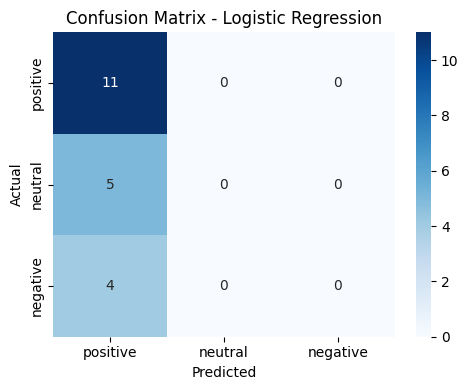

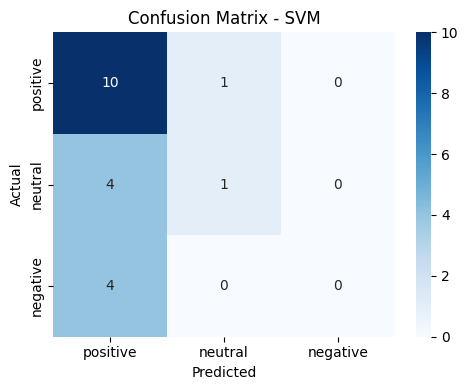

In [71]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load data dan label ===
df = pd.read_excel("Label_Manual_100_Komentar.xlsx")
df = df.dropna(subset=["cleaned_komentar", "sentimen"])

X = df["cleaned_komentar"]
y = df["sentimen"]

# === 2. TF-IDF Vectorizer ===
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(X)

# === 3. Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

# === 4. Model 1: Logistic Regression ===
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# === 5. Model 2: SVM (LinearSVC) ===
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("=== Support Vector Machine (SVM) ===")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# === 6. Visualisasi Confusion Matrix ===
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["positive", "neutral", "negative"],
                yticklabels=["positive", "neutral", "negative"],
                cmap="Blues")
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

plot_cm(y_test, y_pred_lr, "Confusion Matrix - Logistic Regression")
plot_cm(y_test, y_pred_svm, "Confusion Matrix - SVM")


In [74]:
import pandas as pd

# Masukkan hasil evaluasi dari setiap model
roberta = {"model": "RoBERTa",
           "accuracy": 0.95,
           "precision_macro": 0.94,
           "recall_macro": 0.95,
           "f1_macro": 0.94}

logreg = {"model": "TF-IDF + Logistic Regression",
          "accuracy": 0.55,
          "precision_macro": 0.18,
          "recall_macro": 0.33,
          "f1_macro": 0.24}

svm = {"model": "TF-IDF + SVM",
       "accuracy": 0.55,
       "precision_macro": 0.35,
       "recall_macro": 0.37,
       "f1_macro": 0.33}

# Gabungkan ke dalam DataFrame
df_result = pd.DataFrame([roberta, logreg, svm])


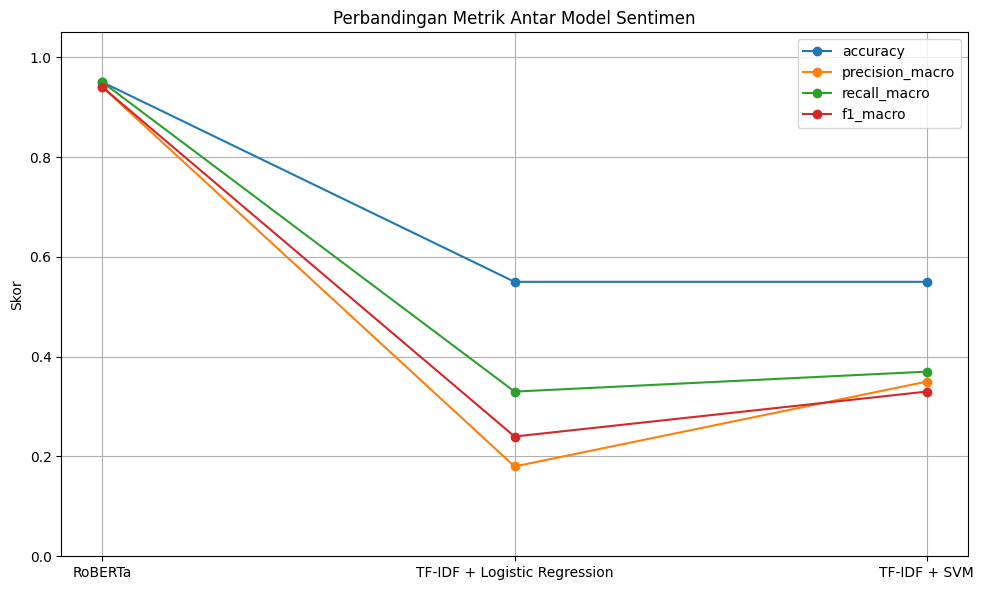

In [75]:
import matplotlib.pyplot as plt

# Daftar metrik yang akan divisualisasikan
metrics = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# Buat plot
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(df_result["model"], df_result[metric], marker='o', label=metric)

plt.title("Perbandingan Metrik Antar Model Sentimen")
plt.ylabel("Skor")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **KESIMPULAN**

Berdasarkan hasil evaluasi terhadap tiga model klasifikasi sentimen, yaitu RoBERTa, TF-IDF + Logistic Regression, dan TF-IDF + SVM, dapat disimpulkan bahwa model berbasis transformer (RoBERTa) secara konsisten memberikan performa terbaik pada semua metrik evaluasi.

Model RoBERTa mencapai skor akurasi sebesar 95%, dengan nilai precision, recall, dan F1-score makro masing-masing sebesar 94–95%. Hal ini menunjukkan bahwa model mampu mengenali berbagai sentimen dengan sangat baik, termasuk pada kelas minoritas seperti negative dan neutral. RoBERTa unggul karena kemampuannya memahami konteks dan nuansa dalam Bahasa Indonesia secara mendalam, berkat pelatihan awal pada korpus besar.

Sebaliknya, model TF-IDF + Logistic Regression dan TF-IDF + SVM menunjukkan performa yang jauh lebih rendah. Logistic Regression memiliki akurasi 55% dan cenderung overfitting pada kelas positive, sementara precision dan recall untuk kelas lain adalah nol. Model SVM sedikit lebih baik dalam mengenali kelas neutral, namun masih gagal dalam mendeteksi kelas negative. Hal ini menunjukkan keterbatasan model tradisional dalam menangkap konteks semantik pada teks pendek dan informal seperti komentar media sosial.

Dengan demikian, model RoBERTa sangat direkomendasikan sebagai model utama untuk analisis sentimen pada teks berbahasa Indonesia, khususnya ketika ketepatan klasifikasi pada semua kelas sentimen menjadi prioritas utama. Model klasik dapat digunakan sebagai baseline atau solusi cepat, namun tidak disarankan untuk kebutuhan klasifikasi yang sensitif atau presisi tinggi.